In [23]:
import pylab
import numpy as np
import warnings
warnings.filterwarnings(action='ignore')
import pandas as pd
import seaborn as sns
import datetime
import matplotlib.pyplot as plt


FIGS_FOLDER = 'figs/rl'
FINAL_PERF = 'Final/Average Final Performance'
ONLINE_PERF = 'Final/Average Online Performance'
SETTING = 'setting'
# METHOD = 'method_full_name'
METHOD = 'method'
DATASET = 'dataset'
RUNTIME = 'Final/Runtime (seconds)'
# LOG_RUNTIME = 'Log Runtime (seconds)'

In [28]:
# some functions

def pareto_filtering(d, methods, N=5, max_run=2):
    lin_interpolations = np.linspace(0, 1, N, endpoint=False)
    to_keep = []
    temp_d = d.copy()

    for method in methods:

        if len(temp_d[temp_d[METHOD]==method])==0:
            continue
            
        to_keep_curr = []

        for interp in lin_interpolations:

            temp_d['cl_score'] =  (1-interp) * temp_d[FINAL_PERF] + interp * temp_d[ONLINE_PERF]

                
            try:
                max_idx = temp_d[temp_d[METHOD]==method]['cl_score'].idxmax()
            except:
                break
#             if max_idx not in to_keep_curr:
            to_keep_curr.append(max_idx)
            temp_d = temp_d.drop(max_idx)
        
            if len(to_keep_curr)>=max_run:
                break
            
        to_keep.extend(to_keep_curr)
        
    return d.loc[to_keep,:]

def mscatter(x,y,z, ax=None, m=None, **kw):
    import matplotlib.markers as mmarkers
    if not ax: ax=plt.gca()
    sc = ax.scatter(x, y, z, **kw)
    if (m is not None) and (len(m)==len(x)):
        paths = []
        for marker in m:
            if isinstance(marker, mmarkers.MarkerStyle):
                marker_obj = marker
            else:
                marker_obj = mmarkers.MarkerStyle(marker)
            path = marker_obj.get_path().transformed(
                        marker_obj.get_transform())
            paths.append(path)
        sc.set_paths(paths)
    return sc


# Read Data

In [4]:
import wandb
api = wandb.Api()

# Project is specified by <entity/project-name>
runs = api.runs("sequoia/crl_study")
summary_list = [] 
config_list = [] 
name_list = [] 
for run in runs: 
    # run.summary are the output key/values like accuracy.
    # We call ._json_dict to omit large files 
    summary_list.append(run.summary._json_dict) 

    # run.config is the input metrics.
    # We remove special values that start with _.
    config = {k:v for k,v in run.config.items() if not k.startswith('_')}
    config_list.append(config) 

    # run.name is the name of the run.
    name_list.append(run.name)       

import pandas as pd 
summary_df = pd.DataFrame.from_records(summary_list) 
config_df = pd.DataFrame.from_records(config_list) 
name_df = pd.DataFrame({'name': name_list}) 

## remove duplicate columns
config_df = config_df.drop(METHOD,1)
config_df = config_df.drop(SETTING,1)

all_df = pd.concat([name_df, config_df,summary_df], axis=1)
data = all_df.copy()

### cleanup

In [36]:
data = all_df.copy()

# remove crashed runs
data = data.dropna(subset=[FINAL_PERF])
data = data.dropna(subset=[ONLINE_PERF])

# drop runs where online perf is 0
data = data[data[ONLINE_PERF]>0]


#rename methods
methods = data[METHOD].values
# TODO(turn this into a map instead of a loop)
for i, method in enumerate(methods):
    if method == 'ppo':
        methods[i] = "SB3.PPO"
    if method == 'sac':
        methods[i] = "SB3.SAC"
    if method == 'td3':
        methods[i] = "SB3.TD3"
    if method == 'ppo':
        methods[i] = "SB3.PPO"
    if method == 'a2c':
        methods[i] = "SB3.A2C"
    if method == 'ddpg':
        methods[i] = "SB3.DDPG"
    if method == 'td3':
        methods[i] = "SB3.TD3"
    if method == 'ppo':
        methods[i] = "SB3.PPO"
    if method == 'dqn':
        methods[i] = "SB3.DQN"
    if method == 'base':
        methods[i] = "BaseMethod"
    if method == 'ewc':
        methods[i] = "EWC"
data[METHOD] = methods

## rename settings
settings = data[SETTING].values
for i, setting in enumerate(settings):
    if setting == 'incremental_rl':
        settings[i] = "Incremental"
    elif setting == 'task_incremental_rl':
        settings[i] = "Task-Incremental"
    elif setting == 'multi_task_rl':
        settings[i] = "Multi-task"
    elif setting == 'traditional_rl':
        settings[i] = "Traditional"
data[SETTING] = settings

## rename datasets
datasets = data[DATASET].values
for i, dataset in enumerate(datasets):
    if dataset == "ContinualHalfCheetah-v2":
        datasets[i] = "HalfCheetah-gravity"
    if dataset == "MetaMonsterKong-v0":
        datasets[i] = "MonsterKong"
data[DATASET] = datasets

# Plot data

zsh:1: no matches found: .figs/rl/*.pdf
2021-10-05_14:55


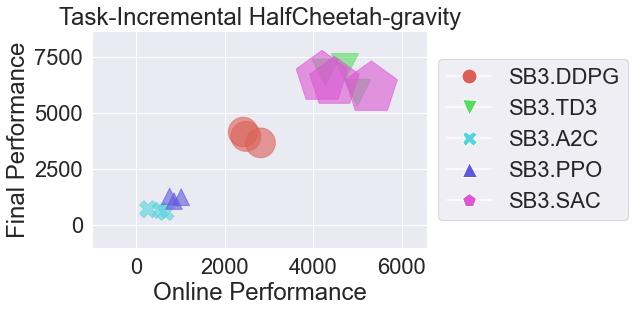

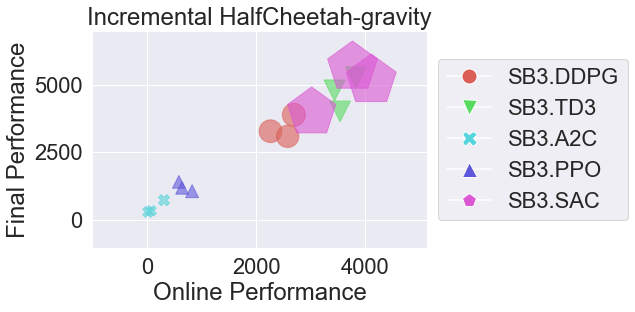

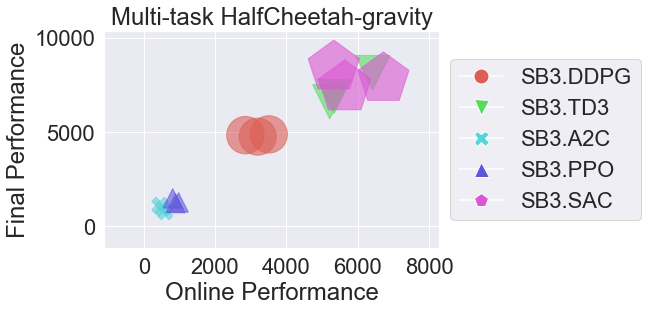

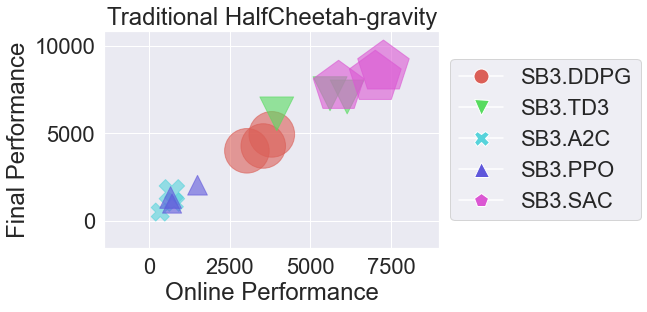

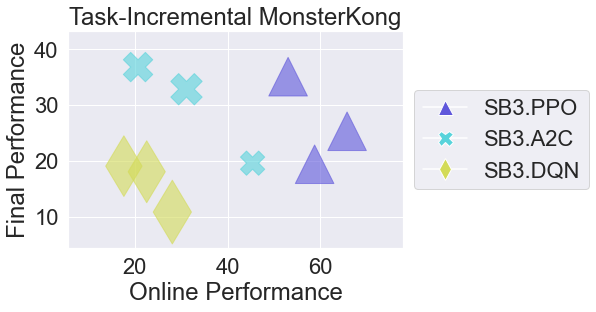

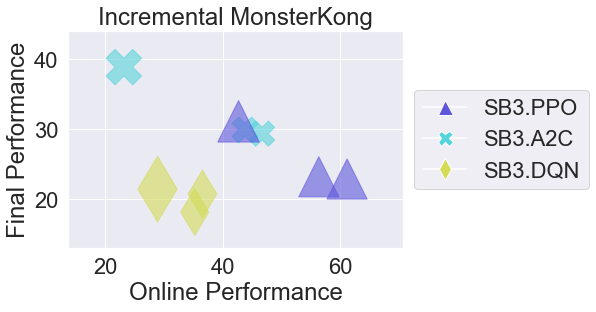

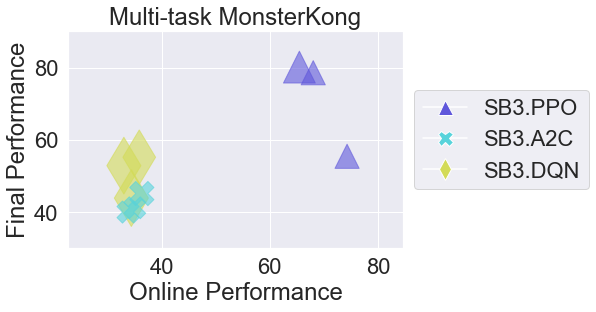

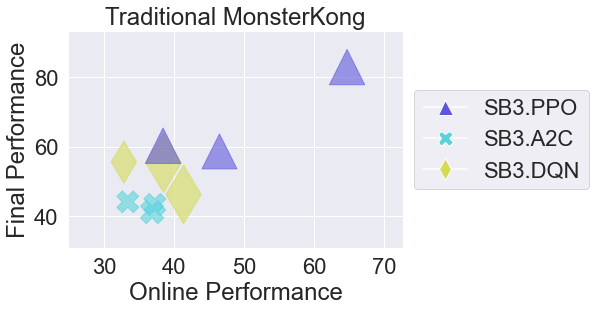

In [38]:
!rm .figs/rl/*.pdf # cleanup existing pdfs in folder
from matplotlib.lines import Line2D # import necessary for the legend

import seaborn as sns
sns.set_theme(style="darkgrid")
sns.set(font_scale=2)  # crazy big

pylab.close('all') # close all open figures

settings = data[SETTING].unique() # get list of all possible settings datasets and methods
methods = list(set(data[METHOD]))
methods.remove('EWC') # not interesting
methods.remove('BaseMethod') # not interesting
datasets = list(set(data[DATASET]))
datasets.remove('CW10'); datasets.remove('CW20'); datasets.remove('MT10'); datasets.remove('CartPole-v0')

colors = sns.color_palette('hls', len(methods)) # assign a color to each method

# data[RUNTIME] /= data[RUNTIME].std() # standarize bubble size
bubble_size_mul = {'HalfCheetah-gravity':1000, 'MountainCarContinuous-v0':1000, 'MonsterKong':500}

time = datetime.datetime.now().strftime("%Y-%m-%d_%H:%M") # get current timestamp to save files

markers = ['o', 'd','v', 'X','^', 'p','<', 's', '>','D'] # assign a marker to each method

# loop over settings and datasets, each one is a plot
for dataset in datasets: 
    for setting in settings: 
        d = data[(data[SETTING] == setting) & (data[DATASET] == dataset)] # filter by settings and dataset
        
        # pareto filtering
        d = pareto_filtering(d, methods, N=3, max_run=4)
        
        # obtain values to plot
        x = d[ONLINE_PERF].values
        y = d[FINAL_PERF].values
        z = d[RUNTIME].values / d[RUNTIME].std() # - np.mean(d[RUNTIME].values)
        
        # manually remove cartpole and plots with less than 2 bubbles
        if len(x[x==x]) < 2 and len(y[y==y]) < 2 or 'CartPole' in data['dataset']:
            continue
            
        fig, ax = pylab.subplots() # create axis
        z = z * bubble_size_mul[dataset] # make the bubbles bigger
        m = [methods.index(_m) for _m in d[METHOD].values] # map method string to integer id
        c = [colors[_m] for _m in m] # use the integer id to get the corresponding color
        _markers = [markers[_m] for _m in m] # use the integer id to get the corresponding marker
        
#         ax.scatter(x, y, z, c, m=_markers, alpha=0.6) # plot
        mscatter(x, y, z, c=c, alpha=0.6, m=_markers) # plot using func w/ markers

        ## make legend and format axis
        legend_elements = [Line2D([0], [0], color='w', label=_m,
                           marker=markers[methods.index(_m)], 
                           markerfacecolor=colors[methods.index(_m)],
                           markersize=15, alpha=1) for _m in set(d[METHOD].values)
        ]   
        xoffset = np.abs(x.max() - x.min()) * 0.25
        yoffset = np.abs(y.max() - y.min()) * 0.25

        pylab.xlim([x.min() - xoffset, x.max() + xoffset])
        pylab.ylim([y.min() - yoffset, y.max() + yoffset])
#         ax.legend(handles=legend_elements, loc='lower right')
        pylab.xlabel("Online Performance")
        pylab.ylabel("Final Performance")
        pylab.title(f'{setting} {dataset}')        
        pylab.savefig(f"{FIGS_FOLDER}/setting={setting}_dataset={dataset}.pdf", bbox_inches="tight")
        ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))
        pylab.savefig(f"{FIGS_FOLDER}/setting={setting}_dataset={dataset}_legend.pdf", bbox_inches="tight")
        
print(time)

In [ ]:
# !tar -czvf rl_plots_absolute_size.tar.gz ./*.pdf